# Info

**Project**

Assessment of gap-filling techniques applied to satellite phytoplankton composition products for the Atlantic Ocean

**Credit**

**© Ehsan Mehdipour**, 2025. (ehsan.mehdipour@awi.de)

Alfred Wegener Insitute for Polar and Marine Research, Bremerhaven, Germany

This work is licensed under the **GNU General Public License v3.0 (GPL-3.0)**. 

**Objective**

This function compute the gradient field using Sobel edge detection algorithms.

**Dataset**

The dataset is accessable through Copernicus Marine Service with the following DOI:
https://doi.org/10.48670/moi-00280 and Dataset ID: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D

# Setup and configuration

## Import modules

In [1]:
# Modules for data analysis
import os
os.environ["OMP_NUM_THREADS"] = "1"
import xarray as xr
import numpy as np
import pandas as pd
import dask
from scipy.ndimage import convolve

# Modules for data visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature
plt.rcParams['text.usetex'] = True
import matplotlib.patches as patches
import matplotlib.ticker as mticker

# Miscellaneous modules
from tqdm import tqdm


# Manual modules or parameters
from function import *
from params import *


## Input and output parameters configuration

In [2]:
# CSV file detailing the boundries of regions of interest (ROI)
regions = pd.read_csv('data/regions.csv', index_col=0)

# Functions (Gradient field)

In [3]:
def apply_convolution(da, kernel):
    '''
    This function apply a convolution on a xr.DataArray.
    
    Parameters:
    da (xr.DataArray): Dataarray from the PFT dataset
    kernel (np.array): a numpy array defining the convolution kernel
    
    Returns:
    convolved_da (xr.DataArray): convolved dataarray
    '''
    convolved_data = convolve(da, kernel)
    convolved_da = xr.DataArray(convolved_data, dims=['lat','lon'], coords = {'lat':da.lat, 'lon':da.lon})
    return convolved_da

def sobel(da, dx=4, dy=4):
    '''
    This function apply all the convolution to the dataarray 
    and compute the root-mean-square.
    
    Parameters:
    da (xr.DataArray): Dataarray from the PFT dataset
    dx (int or float): the pixel dimension of satellite dataset along the x axis
    dy (int or float): the pixel dimension of satellite dataset along the y axis
    
    Returns:
    convt (xr.DataArray): gradient field for the dataarray
    '''
    
    ## Defining the kernels
    kernel1 = np.array([
        [-1,  0,  1],
        [-2,  0,  2],
        [-1,  0,  1]
    ])

    kernel2 = np.array([
        [-1, -2, -1],
        [ 0,  0,  0],
        [ 1,  2,  1]
    ])

    ## Applying the kernels
    conv1 = apply_convolution(da, kernel1)
    conv2 = apply_convolution(da, kernel2)
    
    ## RMS computation
    convt = np.sqrt((conv1/(2*dx))**2 + (conv2/(2*dy))**2)
    return convt

## Call

In [4]:
## Region to consider for gradient field computation
region=10

In [5]:
## Read development dataset for coordinate information
ds_dev = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft_dev.nc'),chunks='auto')
ds_dev = ds_dev[params['PFT']]
time = ds_dev.time
lat = ds_dev.lat
lon = ds_dev.lon
ds_dev = rm_boundry(ds_dev) 

cloud_date_dev = pd.read_csv(os.path.join(params['output_dir'], str(region),'cloud_date_dev.csv'))

In [6]:
## Read test dataset (full dataset)
ds_test = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'ds_pft.nc'),chunks='auto')
ds_test = ds_test[params['PFT']]
ds_test = rm_boundry(ds_test) 

In [7]:
## Read DINCAE reconstructed dataset

experiment='final'

ds_dincae = xr.open_dataset(os.path.join(params['output_dir'], str(region), f'DINCAE/{experiment}/ds_reconstructed.nc'),chunks='auto')
ds_dincae = ds_dincae.assign_coords({'time':time})
ds_dincae = ds_dincae[params['PFT']]
# ds_dincae = ds_dincae.sel(time=cloud_date_train.clouded_date.values).compute()
ds_dincae = rm_boundry(ds_dincae)

In [8]:
## Read DINEOF reconstructed dataset

experiment='final'

ds_dineof = xr.open_mfdataset(os.path.join(params['output_dir'], str(region), 'DINEOF', str(experiment), 'ds_reconstructed_*.nc'))
ds_dineof = ds_dineof.rename(
        {'dim003':'time','dim002':'lat','dim001':'lon'}
    ).assign_coords(
        {'time':time, 'lat':lat,'lon':lon}
    )

ds_dineof = ds_dineof[params['PFT']]
# ds_dineof = ds_dineof.sel(time=cloud_date_train.clouded_date.values).compute()
ds_dineof = rm_boundry(ds_dineof)

In [9]:
## Convert back to linear scale

ds_dineof = 10**ds_dineof
ds_dincae = 10**ds_dincae
ds_test = 10**ds_test
ds_dev = 10**ds_dev

# Computation for all validation days and plot

In [ ]:
## Looping through the validation dates for gradient computation

for t in tqdm(cloud_date_dev['clouded_date']):
    
    ## Gradient detection for TChla
    pft = 'CHL'
    ds_sobel_test_CHL = sobel(ds_test[pft].sel(time=t))
    ds_sobel_dev_CHL = sobel(ds_dev[pft].sel(time=t))
    ds_sobel_dincae_CHL = sobel(ds_dincae[pft].sel(time=t))
    ds_sobel_dineof_CHL = sobel(ds_dineof[pft].sel(time=t))

    
    ## Gradient detection for Diatoms
    pft = 'DIATO'
    ds_sobel_test_DIATO = sobel(ds_test[pft].sel(time=t))
    ds_sobel_dev_DIATO = sobel(ds_dev[pft].sel(time=t))
    ds_sobel_dincae_DIATO = sobel(ds_dincae[pft].sel(time=t))
    ds_sobel_dineof_DIATO = sobel(ds_dineof[pft].sel(time=t))

    ### Ploting
    vmin = 0.001
    vmax = 1

    fig, ax = plt.subplots(2,4, figsize=(12,4), subplot_kw={'projection':ccrs.PlateCarree()}) #10
    # fig, ax = plt.subplots(2,4, figsize=(8,4), subplot_kw={'projection':ccrs.PlateCarree()}) #9

    for a in ax.flat:
        a.set_facecolor('lightblue')

    # cmap = 'coolwarm'
    cmap = 'OrRd'
    alpha= 1
    # cmap='coolwarm'
    p1 = ds_sobel_test_CHL.plot(ax=ax[0,0], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
    ds_sobel_dev_CHL.plot(ax=ax[0,1], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
    ds_sobel_dineof_CHL.plot(ax=ax[0,2], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
    ds_sobel_dincae_CHL.plot(ax=ax[0,3], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)

    p2 = ds_sobel_test_DIATO.plot(ax=ax[1,0], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
    ds_sobel_dev_DIATO.plot(ax=ax[1,1], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
    ds_sobel_dineof_DIATO.plot(ax=ax[1,2], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
    ds_sobel_dincae_DIATO.plot(ax=ax[1,3], cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)

    names = ['Original Sat.', 'Added Cloud', 'DINEOF gap-filled', 'DINCAE gap-filled',]

    for i in range(len(ax[0])):
        ax[0,i].set_title(f'{names[i]}', fontsize='16')

        ax[0,i].add_feature(cartopy.feature.LAND, facecolor='gainsboro',edgecolor='grey', alpha= 1, linewidth=0.3)
        ax[1,i].add_feature(cartopy.feature.LAND, facecolor='gainsboro',edgecolor='grey', alpha= 1, linewidth=0.3)


        gl = ax[0,i].gridlines(draw_labels=True ,alpha=0.2, linestyle='-')
        gl.right_labels = False
        gl.top_labels = False
        gl.bottom_labels = False
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}

#         gl.xlocator = mticker.FixedLocator([0, -5, -10])
#         gl.ylocator = mticker.FixedLocator([45,50])

        if i == 0:
            gl.left_labels = True
        else:
            gl.left_labels = False

        gl = ax[1,i].gridlines(draw_labels=True ,alpha=0.2, linestyle='-')
        gl.right_labels = False
        gl.top_labels = False
        gl.xlabel_style = {'size': 12}
        gl.ylabel_style = {'size': 12}

        # gl.xlocator = mticker.FixedLocator([0, -5, -10])
        # gl.ylocator = mticker.FixedLocator([45,50])

        if i == 0:
            gl.left_labels = True
        else:
            gl.left_labels = False

#         # Rectangle
#         ax[0,i].add_patch(patches.Rectangle((-8, 48.5), 5, 3, linewidth=1, edgecolor='k', facecolor='none'))
#         ax[1,i].add_patch(patches.Rectangle((-8, 48.5), 5, 3, linewidth=1, edgecolor='k', facecolor='none'))

#         ax[0,i].add_patch(patches.Rectangle((-6, 43), 6, 5, linewidth=1, edgecolor='k', facecolor='none'))
#         ax[1,i].add_patch(patches.Rectangle((-6, 43), 6, 5, linewidth=1, edgecolor='k', facecolor='none'))

#         ax[0,i].text(-4,50.5,'1', fontweight='bold', fontsize=14, color='k')
#         ax[1,i].text(-4,50.5,'1', fontweight='bold', fontsize=14, color='k')

#         ax[0,i].text(-1.1,46.7,'2', fontweight='bold', fontsize=14, color='k')
#         ax[1,i].text(-1.1,46.7,'2', fontweight='bold', fontsize=14, color='k')

    fig.text(-0.01, 0.70, 'TChla', va='center', rotation='vertical', fontsize=18, fontweight='bold')
    fig.text(-0.01, 0.30, 'Diatoms', va='center', rotation='vertical', fontsize=18, fontweight='bold')

    plt.tight_layout()
    cbar = plt.colorbar(p1, ax=ax[:,:], orientation="vertical",extend='both', pad=0.01, shrink=0.7)
    # cbar = plt.colorbar(p2, ax=ax[1,:], orientation="vertical",extend='both', pad=0.01, shrink=0.7)
    cbar.set_ticks([0.001,0.01,0.1,1])
    cbar.set_ticklabels([0.001,0.01,0.1,1])
    cbar.set_label(r'Gradient $[mg \cdot m^{-4}]$', fontsize=14)
    # plt.show()

    plt.savefig(os.path.join(params['fig_dir'],'regions', region, f'/Grad/chl_and_diato_{t}.png'), dpi=300, bbox_inches='tight')
    plt.close()

# Specific date plot

In [10]:
## Date of the final plot
t = '2018-06-23'

## Gradient detection for TChla
pft = 'CHL'
ds_sobel_test_CHL = sobel(ds_test[pft].sel(time=t))
ds_sobel_dev_CHL = sobel(ds_dev[pft].sel(time=t))
ds_sobel_dincae_CHL = sobel(ds_dincae[pft].sel(time=t))
ds_sobel_dineof_CHL = sobel(ds_dineof[pft].sel(time=t))

## Gradient detection for Diatoms
pft = 'DIATO'
ds_sobel_test_DIATO = sobel(ds_test[pft].sel(time=t))
ds_sobel_dev_DIATO = sobel(ds_dev[pft].sel(time=t))
ds_sobel_dincae_DIATO = sobel(ds_dincae[pft].sel(time=t))
ds_sobel_dineof_DIATO = sobel(ds_dineof[pft].sel(time=t))

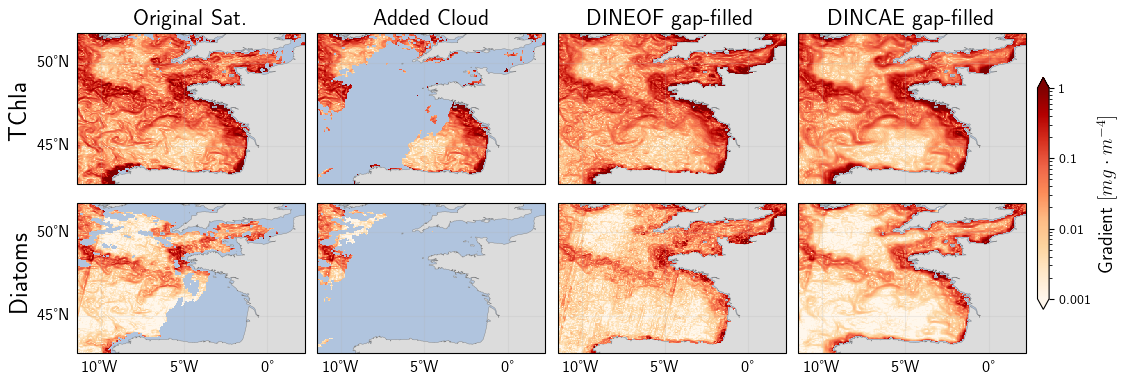

In [11]:
## Ploting procedure

fig, ax = plt.subplots(2,4, figsize=(12,4), subplot_kw={'projection':ccrs.PlateCarree()})

vmin=0.001
vmax=1

for a in ax.flat:
    a.set_facecolor('lightsteelblue')

# cmap = 'coolwarm'
cmap = 'OrRd'
alpha= 1
# cmap='coolwarm'
p1 = ds_sobel_test_CHL.plot(ax=ax[0,0], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
ds_sobel_dev_CHL.plot(ax=ax[0,1], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
ds_sobel_dineof_CHL.plot(ax=ax[0,2], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
ds_sobel_dincae_CHL.plot(ax=ax[0,3], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)

p2 = ds_sobel_test_DIATO.plot(ax=ax[1,0], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
ds_sobel_dev_DIATO.plot(ax=ax[1,1], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
ds_sobel_dineof_DIATO.plot(ax=ax[1,2], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)
ds_sobel_dincae_DIATO.plot(ax=ax[1,3], cmap=cmap, norm= LogNorm(vmin=vmin, vmax=vmax), add_colorbar=False, transform=ccrs.PlateCarree(), alpha=alpha)

names = ['Original Sat.', 'Added Cloud', 'DINEOF gap-filled', 'DINCAE gap-filled',]

for i in range(len(ax[0])):
    ax[0,i].set_title(f'{names[i]}', fontsize='16')
    
    ax[0,i].add_feature(cartopy.feature.LAND, facecolor='gainsboro',edgecolor='grey', alpha= 1, linewidth=0.3)
    ax[1,i].add_feature(cartopy.feature.LAND, facecolor='gainsboro',edgecolor='grey', alpha= 1, linewidth=0.3)

    
    gl = ax[0,i].gridlines(draw_labels=True ,alpha=0.2, linestyle='-')
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    
    gl.xlocator = mticker.FixedLocator([0, -5, -10])
    gl.ylocator = mticker.FixedLocator([45,50])

    if i == 0:
        gl.left_labels = True
    else:
        gl.left_labels = False
    
    gl = ax[1,i].gridlines(draw_labels=True ,alpha=0.2, linestyle='-')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    
    gl.xlocator = mticker.FixedLocator([0, -5, -10])
    gl.ylocator = mticker.FixedLocator([45,50])

    if i == 0:
        gl.left_labels = True
    else:
        gl.left_labels = False

#     # Rectangle
#     ax[0,i].add_patch(patches.Rectangle((-10, 45), 4, 4, linewidth=1, edgecolor='k', facecolor='none'))
#     ax[1,i].add_patch(patches.Rectangle((-10, 45), 4, 4, linewidth=1, edgecolor='k', facecolor='none'))
    
#     ax[0,i].add_patch(patches.Rectangle((-4, 43), 4, 5, linewidth=1, edgecolor='k', facecolor='none'))
#     ax[1,i].add_patch(patches.Rectangle((-4, 43), 4, 5, linewidth=1, edgecolor='k', facecolor='none'))
    
#     ax[0,i].text(-7,48,'1', fontweight='bold', fontsize=14, color='k')
#     ax[1,i].text(-7,48,'1', fontweight='bold', fontsize=14, color='k')

#     ax[0,i].text(-1.1,46.7,'2', fontweight='bold', fontsize=14, color='k')
#     ax[1,i].text(-1.1,46.7,'2', fontweight='bold', fontsize=14, color='k')
    
fig.text(-0.01, 0.70, 'TChla', va='center', rotation='vertical', fontsize=18, fontweight='bold')
fig.text(-0.01, 0.30, 'Diatoms', va='center', rotation='vertical', fontsize=18, fontweight='bold')

plt.tight_layout()
cbar = plt.colorbar(p1, ax=ax[:,:], orientation="vertical",extend='both', pad=0.01, shrink=0.7)
# cbar = plt.colorbar(p2, ax=ax[1,:], orientation="vertical",extend='both', pad=0.01, shrink=0.7)
cbar.set_ticks([0.001,0.01,0.1,1])
cbar.set_ticklabels([0.001,0.01,0.1,1])
cbar.set_label(r'Gradient $[mg \cdot m^{-4}]$', fontsize=14)
# plt.show()

plt.savefig(os.path.join(params['fig_dir'],f'gradient_field_area{region}_{t}.png'), dpi=300, bbox_inches='tight')
# plt.close()